# Unsupervised Anomaly Detection of Numenta Anomaly Benchmark
---
The Numenta Anomaly Benchmark (NAB) contains various datasets that are useful testbeds for testing anomaly detection processes as well as exploring methodologies more closely.

  In this notebook I'll be exploring the exchange-4_cpm_results.csv dataset which holds information related to an advertisements Clicks-Per-Minute.

In [1]:
import pandas as pd #DataFrames
df = pd.read_csv('../data/external/exchange-4_cpm_results.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1643 entries, 0 to 1642
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1643 non-null   object 
 1   value      1643 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.8+ KB
None
             timestamp     value
0  2011-07-01 00:15:01  0.618226
1  2011-07-01 01:15:01  0.506628
2  2011-07-01 02:15:01  0.399551
3  2011-07-01 03:15:01  0.482681
4  2011-07-01 04:15:01  0.306038


Here our data shows that the timestamp column is identified as an object instead of the datetime python value. It would most likely be beneficial to split this timestamp up into:

| Month | Day | Hour |
|-------|-----|------|

while dropping the year, minutes, and seconds from the value since it appears static from intiial viewing of the data.

In [2]:
df.timestamp = df.timestamp.apply(pd.to_datetime)
df['Month'] = [d.month for d in df['timestamp']]
df['Day'] = [d.day for d in df['timestamp']]
df['Hour'] = [d.hour for d in df['timestamp']]
df = df.drop('timestamp', 1)
print(df.tail())
print(df.nunique());
print(df['value'].describe())

         value  Month  Day  Hour
1638  0.253277      9    7    10
1639  0.361301      9    7    11
1640  0.304388      9    7    12
1641  0.287671      9    7    13
1642  0.299011      9    7    14
value    1641
Month       3
Day        31
Hour       24
dtype: int64
count    1643.000000
mean        0.533830
std         0.747022
min         0.121520
25%         0.360400
50%         0.467618
75%         0.583870
max        16.438200
Name: value, dtype: float64


Plotting the cleaned up dataset to see if there is any obvious approaches to identifying anomalies in this dataset.

Because the timestamp was cleaned up but the order of the columns is retained we will simply plot from top to bottom of the dataframe to provide the same time evolution that would be evident in plotting timestamp vs value

Text(0.5, 1.0, 'CPM over time')

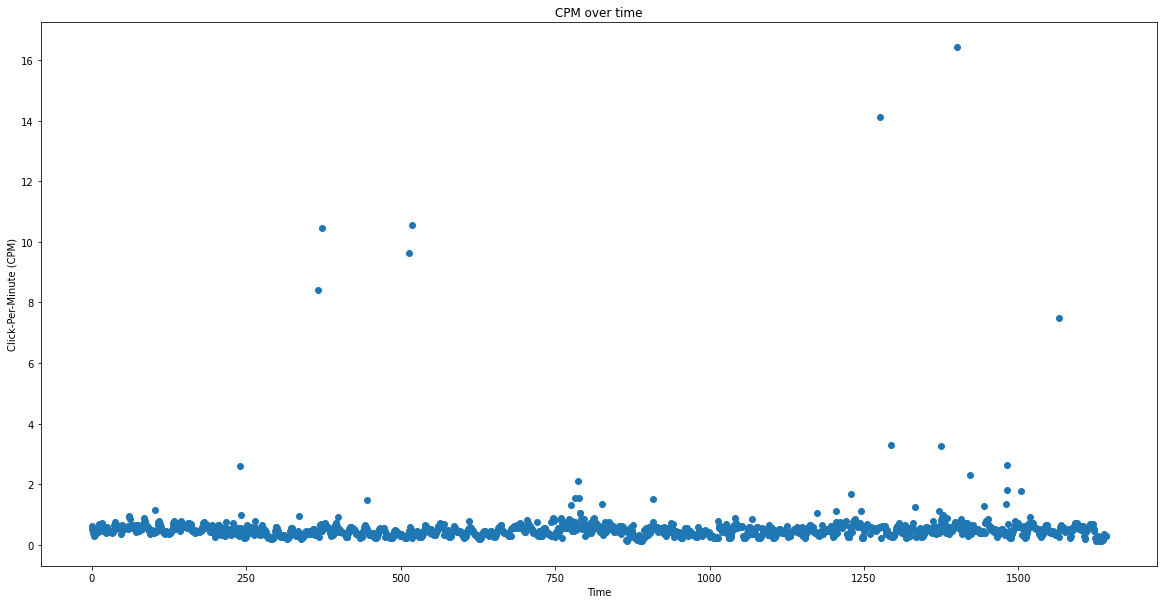

In [3]:
import matplotlib.pyplot as plt #Plotting library
plt.figure(figsize=(20,10))
plt.scatter(range(df.shape[0]), df['value'].values)
plt.xlabel('Time')
plt.ylabel('Click-Per-Minute (CPM)')
plt.title('CPM over time')

## Initial Observations

Time did not provide much useful insight but just looking at the plotted data various anomalies are easily identified as the data sits well below 2 normally. The mean of the data is **0.534** while the std is **0.747** indicating that a majority of the data will fall below **1.28**.

## Inter-Quartile Range (IQR)
With our data transformed into a much more usable format we can try some basic anomaly detection. In this case using the IQR we can clip off the obvious anomalies well outside the mean &plusmn; std.

count    821.000000
mean       0.472640
std        0.062841
min        0.360419
25%        0.420960
50%        0.467618
75%        0.529904
max        0.583843
Name: value, dtype: float64


Text(0.5, 1.0, 'IQR CPM over time')

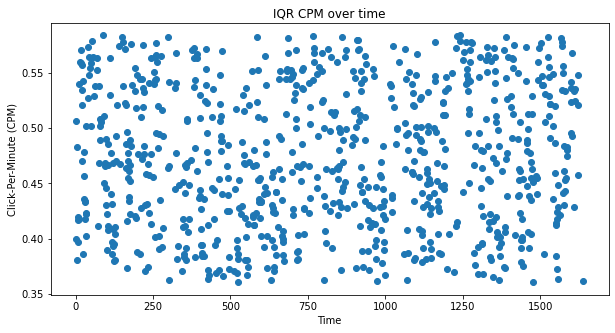

In [4]:
df_iqr = df[df.value > 0.360400]
df_iqr = df_iqr[df_iqr.value < 0.583870]
print(df_iqr.value.describe())
plt.figure(figsize=(10,5))
plt.scatter(df_iqr.index, df_iqr['value'].values)
plt.xlabel('Time')
plt.ylabel('Click-Per-Minute (CPM)')
plt.title('IQR CPM over time')

### IQR Result
The IQR method certainly reduces the destribution to be more uniform which would indicate a reduction in anomalies but as expected from the IQR method the overall data is reduced by 50% even though it appeared there were only a few anomalies. This is not a good method for anomaly reduction for this dataset as I would not expect 50% of the data to be anomalous

## Local Outlier Factor (LOF)
Because the dataset shows some relatively high anomalous values it may be more accurate to use LOF with 3 neighbours where ideally 1 neighbour captures the high anomalous outliers, 1 neighbour captures the low anomalous outliers, and 1 holds onto the normal values.

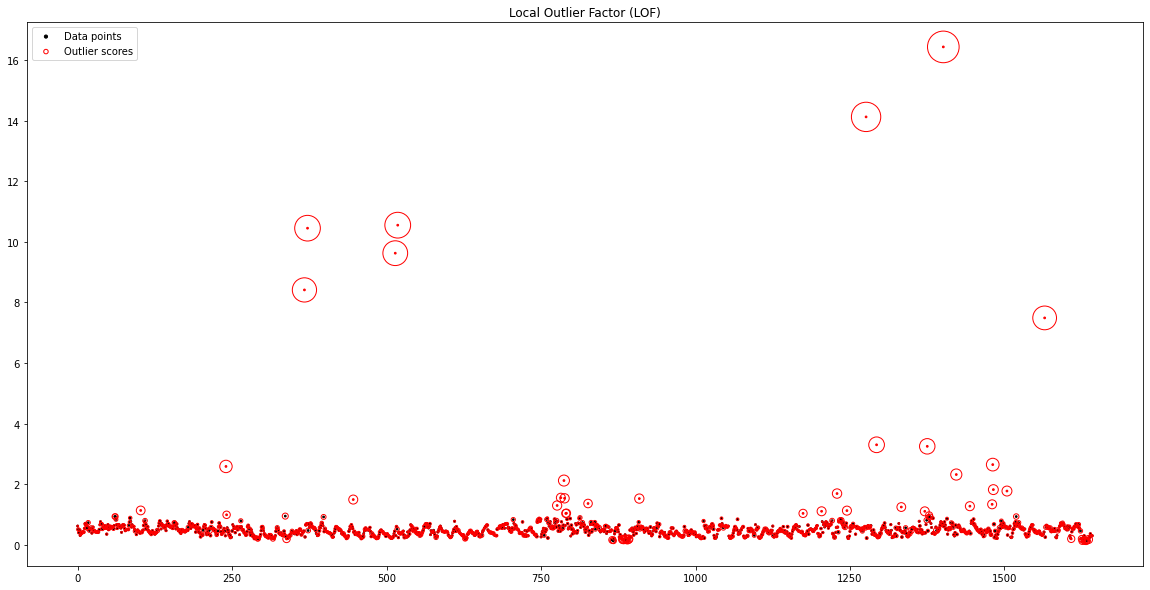

In [5]:
from sklearn.neighbors import LocalOutlierFactor #LOF from Scikit
model_lor = LocalOutlierFactor(n_neighbors=20)
y_pred = model_lor.fit_predict(df.value.values.reshape(-1,1))

import numpy as np #Where function
outlier_factor = model_lor.negative_outlier_factor_
col = np.where(y_pred==-1,'r','k')

#Plotting settings from documentation at:
#https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html
plt.figure(figsize=(20,10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(df.index, df.value, color=col, s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (outlier_factor.max() - outlier_factor) / (outlier_factor.max() - outlier_factor.min())
plt.scatter(df.index, df.value, s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [6]:
print('Number of anomalies:', np.where(y_pred==-1)[0].size)

Number of anomalies: 47


count    1596.000000
mean        0.472492
std         0.149156
min         0.131991
25%         0.360491
50%         0.465689
75%         0.576892
max         0.946560
Name: value, dtype: float64


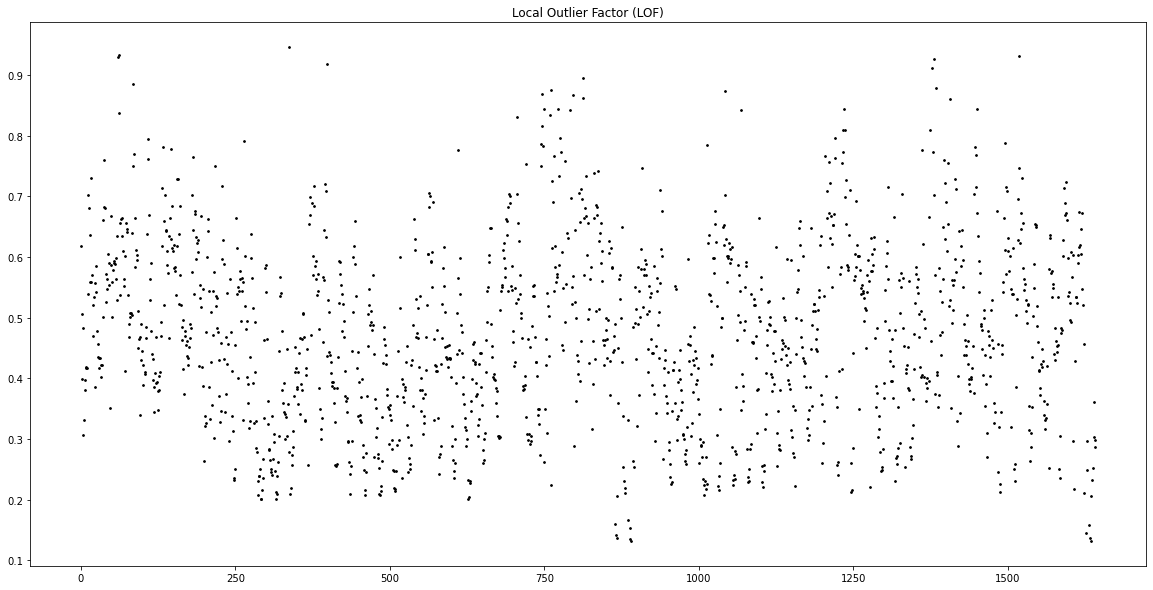

In [7]:
no_anomaly = df.drop(np.where(y_pred==-1)[0])
print(no_anomaly.value.describe())
plt.figure(figsize=(20,10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(no_anomaly.index, no_anomaly.value, color='k', s=3., label='Data points')

### LOF Result
LOF produced far less anomaly labels while still providing a relatively well grouped set of data as displayed in the above plot. The data could still be trimmed slightly when looking at the data where the values above 0.9 and below 0.2 could be dropped with minimal reduction in valid data. The overall spread of the data is also far tighter and the number of valid datapoints is:

$${1596 \over 1643} = 97.14\%$$

This is a far better outcome compared to the 50% valid data granted by using the IQR method introduced above.

In [8]:
#Serializing model
import pickle #used for serializing
pickle.dump(model_lor, open('../models/LOF_Model.sav', 'wb'))

# Conclusion
---
From the two observed methods there are pros and cons with implementation on the clicks-per-minute dataset which only contained the timestamp and the value at said timestamp.

* IQR
  * Pros:
    * Easy to implement
    * Datapoints are generally going to be valid
  * Cons:
    * Many false negatives
    * Gauranteed to lose 50% of overall data
* LOR
  * Pros:
    * Simple to understand and can be tuned to dataset if data is easily interpreted
    * Data that is expected to hover around an expected value can have anomalies easily identified as outside the normal values
    * Easy to visualize the predicted anomalies
  * Cons:
    * Using such a method can either overlabel anomalies or underlabel as there isn't a fine tuning mechanism like with K-Means clustering that allows the initial points to be declared
    * The LOR score by itself is difficult to understand but can still be utilized to help with visualization as in the first figure.
    
Unfortunately the timestamp divided into Month/Day/Hour didn't provide much usage in this modeling as the overall timestamp was simply used for plotting details.